In [1]:
#loading a spiketimes numpy file
import numpy as np

data = np.load("/Users/mandarmp/Documents/PHD/well000/spike_times_clean.npz", allow_pickle=False)
spiketimes = {k: data[k] for k in data.files}

In [2]:
bin_size = 0.20 # seconds (20 ms)

In [3]:
#add this to system path
import sys
sys.path.append('/Users/mandarmp/Documents/Projects/MEA_Analysis_MAINBRANCH/IPNAnalysis')


In [4]:
from IPNAnalysis import helper_functions

(0.0, 10.0)

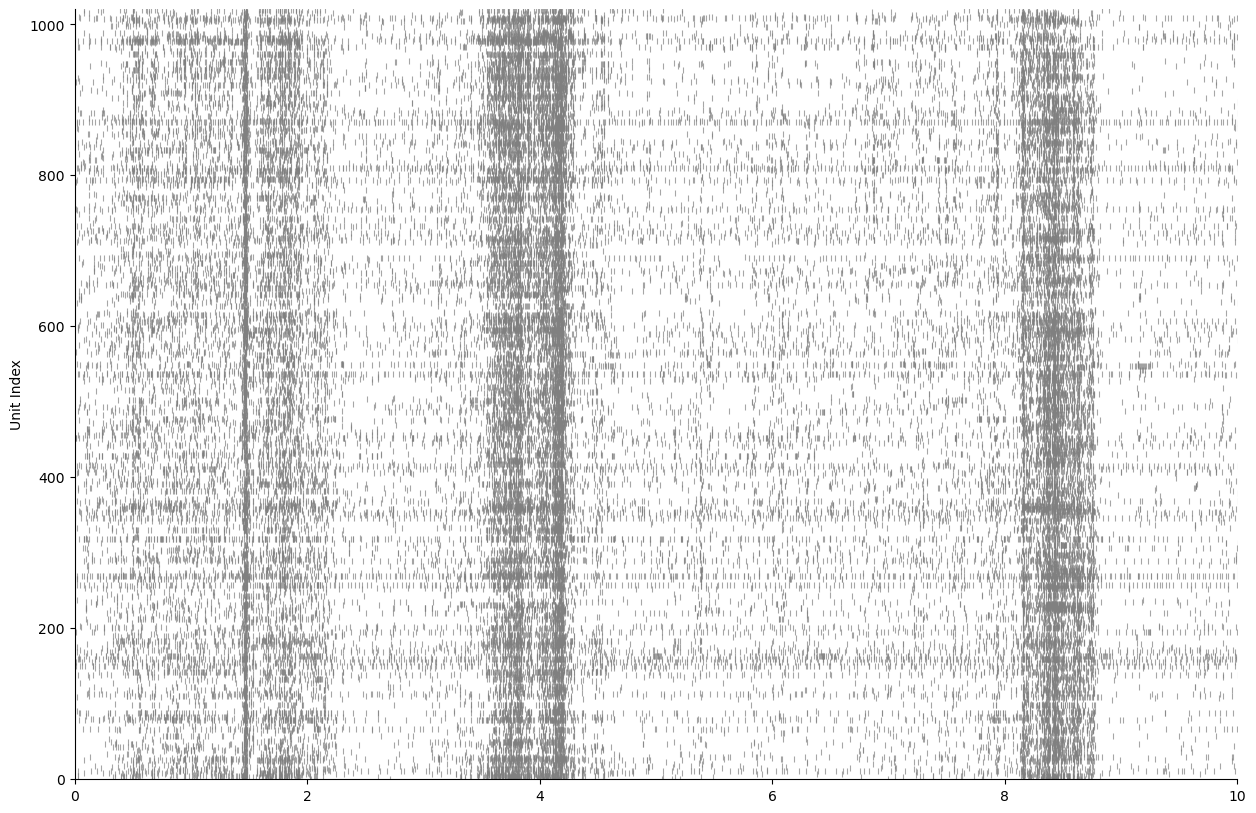

In [5]:
import matplotlib.pyplot as plt
fig , ax =  plt.subplots(figsize=(15,10))
helper_functions.plot_clean_raster(ax, spiketimes)
ax.set_xlim(0,10)

In [6]:
# Get global start/end
t_start = min(times[0] for times in spiketimes.values() if len(times) > 0)
t_end   = max(times[-1] for times in spiketimes.values() if len(times) > 0)


In [7]:
bins = np.arange(t_start, t_end + bin_size, bin_size)
t_centers = (bins[:-1] + bins[1:]) / 2.0

T = len(t_centers)
print("Number of time bins:", T)

Number of time bins: 1501


# Pop rate

In [8]:
population_rate = np.zeros(T)

for unit, times in spiketimes.items():
    counts, _ = np.histogram(times, bins=bins)
    population_rate += counts

# convert counts → Hz
population_rate = population_rate / bin_size

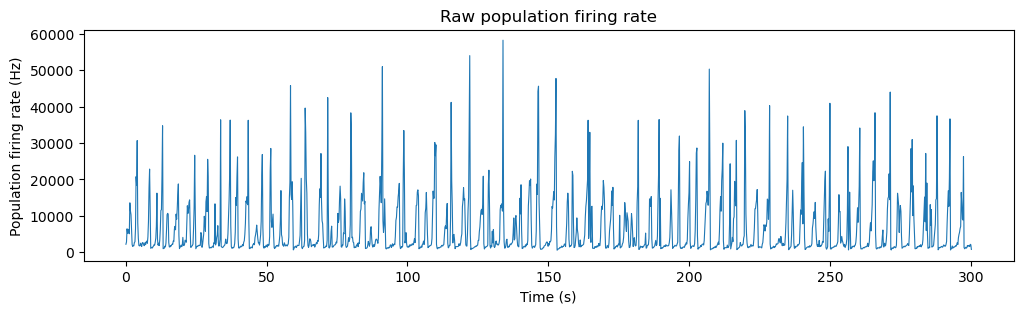

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 3))
plt.plot(t_centers, population_rate, lw=0.8)
plt.xlabel("Time (s)")
plt.ylabel("Population firing rate (Hz)")
plt.title("Raw population firing rate")
plt.show()

In [10]:
from scipy.ndimage import gaussian_filter1d

sigma_bins = 2.0  # ≈ 50 ms smoothing
pop_rate_smooth = gaussian_filter1d(population_rate, sigma_bins)

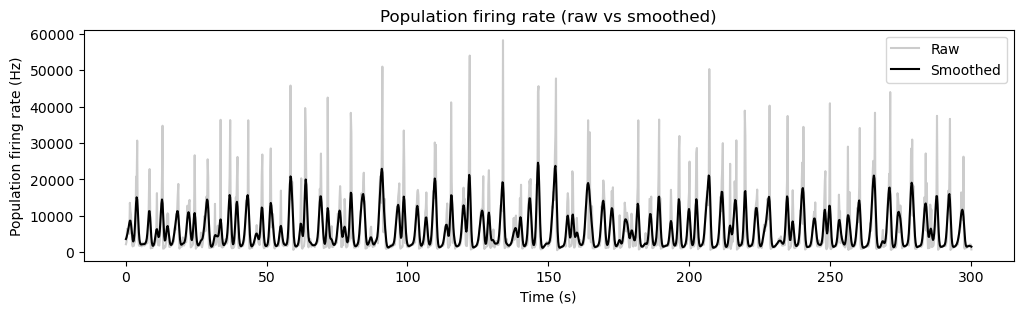

In [11]:
plt.figure(figsize=(12, 3))
plt.plot(t_centers, population_rate, color="gray", alpha=0.4, label="Raw")
plt.plot(t_centers, pop_rate_smooth, color="black", lw=1.5, label="Smoothed")
plt.xlabel("Time (s)")
plt.ylabel("Population firing rate (Hz)")
plt.legend()
plt.title("Population firing rate (raw vs smoothed)")
plt.show()

In [12]:
unit_ids = list(spiketimes.keys())
N = len(unit_ids)

rates = np.zeros((T, N))

for j, u in enumerate(unit_ids):
    counts, _ = np.histogram(spiketimes[u], bins=bins)
    rates[:, j] = counts / bin_size  # Hz

print("rates shape:", rates.shape)

rates shape: (1501, 1020)


In [13]:
good = rates.std(axis=0) > 1e-6
rates = rates[:, good]

print("Units after cleanup:", rates.shape[1])

Units after cleanup: 1020


pairing each pop activity vector with the one that follows it in time so I can fit a linear map from the current state to the next state. Here each pop act per bin will represent like a state.

In [22]:
X = rates[:-1, :]
Y = rates[1:, :]

print("X shape:", X.shape)

X shape: (1500, 1020)


In [15]:
import numpy.linalg as nla

def fit_linear_dynamical_system_basic(X, Y):
    assert X.shape == Y.shape
    assert X.shape[0] > X.shape[1]
    return nla.pinv(X) @ Y

A = fit_linear_dynamical_system_basic(X, Y)

print("A shape:", A.shape)

A shape: (1020, 1020)


In [16]:
eigvals = np.linalg.eigvals(A)

spectral_radius = np.max(np.abs(eigvals))
print("Spectral radius:", spectral_radius)

Spectral radius: 0.9986379774679166


In [23]:
dt = 0.02  # seconds
lam = spectral_radius
tau = -dt / np.log(lam)
print("Time constant (s):", tau)

Time constant (s): 14.674042616723556


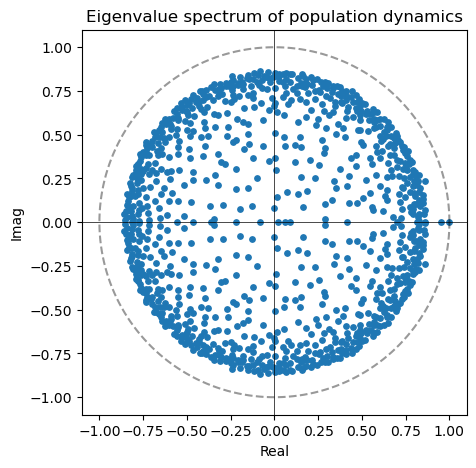

In [24]:
import matplotlib.pyplot as plt

theta = np.linspace(0, 2*np.pi, 400)

plt.figure(figsize=(5,5))
plt.plot(np.cos(theta), np.sin(theta), 'k--', alpha=0.4)
plt.scatter(eigvals.real, eigvals.imag, s=15)
plt.axhline(0, color='k', lw=0.5)
plt.axvline(0, color='k', lw=0.5)
plt.gca().set_aspect('equal')
plt.xlabel("Real")
plt.ylabel("Imag")
plt.title("Eigenvalue spectrum of population dynamics")
plt.show()

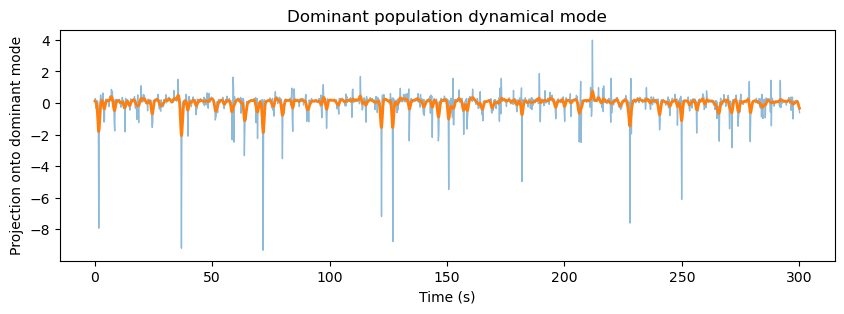

In [25]:
eigvals, eigvecs = np.linalg.eig(A)
idx = np.argmax(np.abs(eigvals))

v_dom = np.real(eigvecs[:, idx])
v_dom /= np.linalg.norm(v_dom)

rates_zc = (rates - rates.mean(axis=0)) / rates.std(axis=0)
proj = rates_zc @ v_dom
proj_smooth = gaussian_filter1d(proj, sigma=2)
plt.figure(figsize=(10,3))
plt.plot(t_centers[:3000], proj[:3000], lw=1, alpha=0.5)
plt.plot(t_centers[:3000], proj_smooth[:3000], lw=2)
plt.xlabel("Time (s)")
plt.ylabel("Projection onto dominant mode")
plt.title("Dominant population dynamical mode")
plt.show()

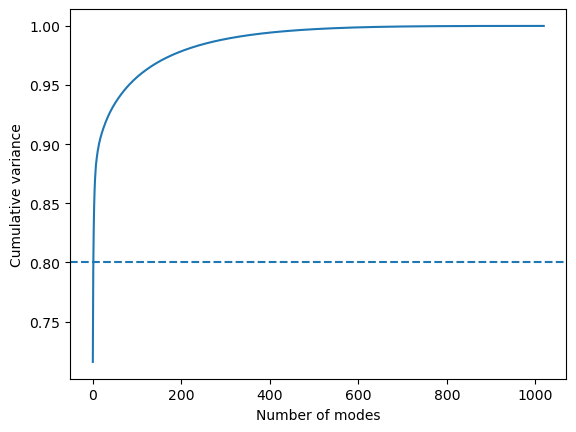

In [20]:
U, S, Vt = np.linalg.svd(X, full_matrices=False)
var_explained = np.cumsum(S**2) / np.sum(S**2)

plt.plot(var_explained)
plt.axhline(0.8, ls='--')
plt.xlabel("Number of modes")
plt.ylabel("Cumulative variance")
plt.show()

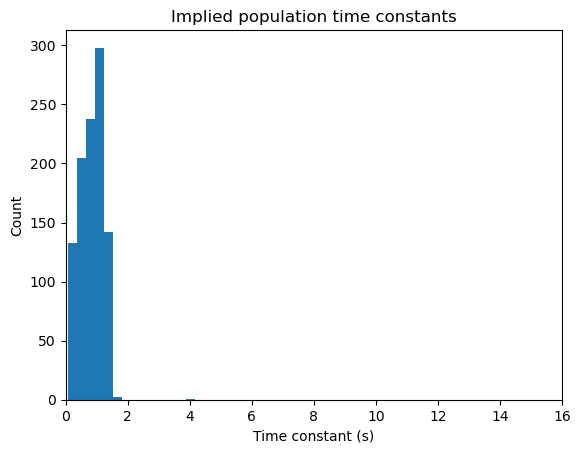

In [30]:
dt = bin_size  # in seconds
taus = -dt / np.log(np.abs(eigvals))

# remove invalid values
taus = taus[np.isfinite(taus) & (taus > 0)]

plt.hist(taus, bins=500)
plt.xlabel("Time constant (s)")
plt.ylabel("Count")
plt.title("Implied population time constants")
plt.xlim(0, 16)
plt.show()

with my burst detector knowledge

In [33]:


unit_ids = list(spiketimes.keys())
N = len(unit_ids)

rates = np.zeros((T, N))

for j, unit in enumerate(unit_ids):
    counts, _ = np.histogram(spiketimes[unit], bins=bins)
    rates[:, j] = counts / bin_size  # Hz

print("Rates shape:", rates.shape)

Rates shape: (1501, 1020)


In [34]:
# Remove units with ~zero variance
good_units = rates.std(axis=0) > 1e-6

rates = rates[:, good_units]
unit_ids = [u for u, g in zip(unit_ids, good_units) if g]

print(f"Remaining units: {rates.shape[1]}")

Remaining units: 1020


In [35]:
import json

with open("/Users/mandarmp/Documents/PHD/well000/network_results.json", "r") as f:
    burst_json = json.load(f)

network_events = burst_json["network_bursts"]["events"]

print(f"Loaded {len(network_events)} network bursts")

Loaded 101 network bursts


In [36]:
burst_mask = np.zeros(T, dtype=bool)

for ev in network_events:
    s = ev["start"]
    e = ev["end"]

    idx = np.where((t_centers >= s) & (t_centers <= e))[0]
    burst_mask[idx] = True

print("Burst bins:", burst_mask.sum())

Burst bins: 608


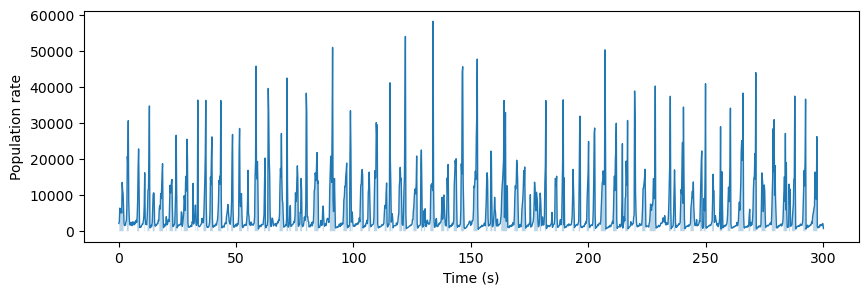

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.plot(t_centers, rates.sum(axis=1), lw=1)
plt.fill_between(
    t_centers,
    0,
    rates.sum(axis=1),
    where=burst_mask,
    alpha=0.3
)
plt.xlabel("Time (s)")
plt.ylabel("Population rate")
plt.show()

In [40]:
rates_z = (rates - rates.mean(axis=0)) / rates.std(axis=0)

In [41]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(rates_z)

explained = np.cumsum(pca.explained_variance_ratio_)

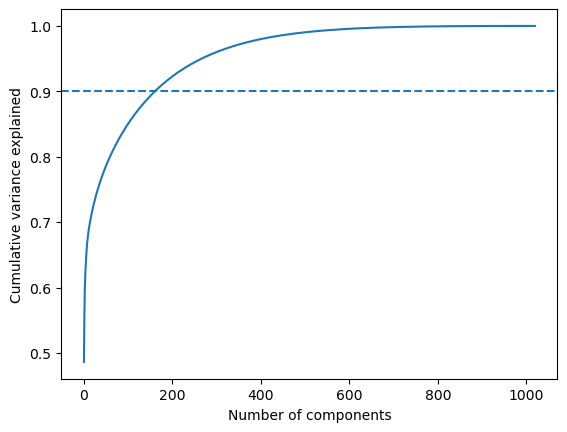

In [42]:
plt.plot(explained)
plt.axhline(0.9, ls='--')
plt.xlabel("Number of components")
plt.ylabel("Cumulative variance explained")
plt.show()

In [ ]:
K = 30  # example
rates_pca = pca.transform(rates_z)[:, :K]

In [44]:
Xb = rates_pca[idx, :]
Yb = rates_pca[idx + 1, :]

print(Xb.shape)

(509, 175)


In [47]:
A_burst = np.linalg.pinv(Xb) @ Yb
print(A_burst.shape)

(175, 175)


In [46]:
eigvals = np.linalg.eigvals(A_burst)
rho_burst = np.max(np.abs(eigvals))

print("Spectral radius (burst):", rho_burst)

Spectral radius (burst): 0.8239876323016765


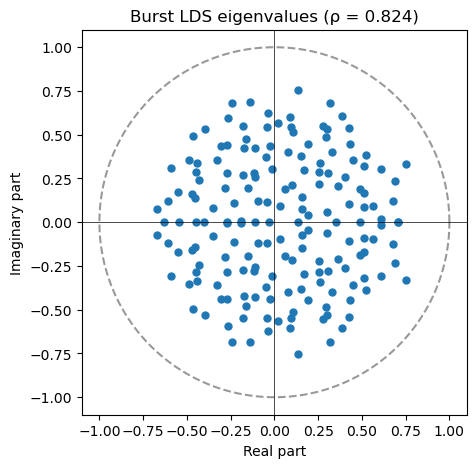

In [48]:
import numpy as np
import matplotlib.pyplot as plt

theta = np.linspace(0, 2*np.pi, 400)

plt.figure(figsize=(5, 5))

# unit circle
plt.plot(np.cos(theta), np.sin(theta), 'k--', alpha=0.4)

# eigenvalues
plt.scatter(eigvals.real, eigvals.imag, s=25)

plt.axhline(0, color='k', lw=0.5)
plt.axvline(0, color='k', lw=0.5)
plt.gca().set_aspect('equal')

plt.xlabel("Real part")
plt.ylabel("Imaginary part")
plt.title(f"Burst LDS eigenvalues (ρ = {rho_burst:.3f})")
plt.show()

In [49]:
idx_inter = np.where(~burst_mask[:-1] & ~burst_mask[1:])[0]

print("Burst transitions:", len(idx))
print("Inter-burst transitions:", len(idx_inter))

Burst transitions: 509
Inter-burst transitions: 793


In [50]:
# inter-burst
Xi = rates_pca[idx_inter, :]
Yi = rates_pca[idx_inter + 1, :]

In [51]:
A_inter = np.linalg.pinv(Xi) @ Yi

In [52]:
eig_inter = np.linalg.eigvals(A_inter)
rho_inter = np.max(np.abs(eig_inter))
print("Spectral radius (inter-burst):", rho_inter)

Spectral radius (inter-burst): 0.9697687858288059


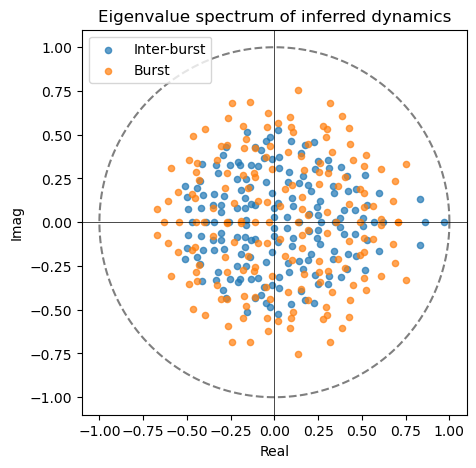

In [53]:
import matplotlib.pyplot as plt
import numpy as np

eigvals_burst = np.linalg.eigvals(A_burst)
eigvals_inter = np.linalg.eigvals(A_inter)

theta = np.linspace(0, 2*np.pi, 400)

plt.figure(figsize=(5,5))
plt.plot(np.cos(theta), np.sin(theta), 'k--', alpha=0.5)  # unit circle

plt.scatter(
    eigvals_inter.real,
    eigvals_inter.imag,
    s=20,
    alpha=0.7,
    label="Inter-burst"
)

plt.scatter(
    eigvals_burst.real,
    eigvals_burst.imag,
    s=20,
    alpha=0.7,
    label="Burst"
)

plt.axhline(0, color='k', lw=0.5)
plt.axvline(0, color='k', lw=0.5)
plt.gca().set_aspect('equal')

plt.xlabel("Real")
plt.ylabel("Imag")
plt.legend()
plt.title("Eigenvalue spectrum of inferred dynamics")
plt.show()

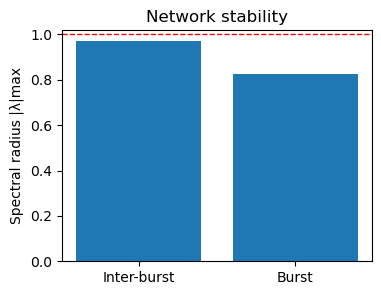

In [54]:
rho_burst = np.max(np.abs(eigvals_burst))
rho_inter = np.max(np.abs(eigvals_inter))

plt.figure(figsize=(4,3))
plt.bar(["Inter-burst", "Burst"], [rho_inter, rho_burst])
plt.axhline(1.0, color='r', ls='--', lw=1)
plt.ylabel("Spectral radius |λ|max")
plt.title("Network stability")
plt.show()

In [55]:
rho_burst = np.max(np.abs(eigvals_burst))
rho_inter = np.max(np.abs(eigvals_inter))

print("ρ inter:", rho_inter)
print("ρ burst:", rho_burst)
print("Δρ:", rho_burst - rho_inter)

ρ inter: 0.9697687858288059
ρ burst: 0.8239876323016765
Δρ: -0.1457811535271294
